In [119]:

from google.colab import files
uploaded = files.upload()


Saving usu_individual_t104.dta to usu_individual_t104 (1).dta
Saving usu_individual_T124.xlsx to usu_individual_T124 (1).xlsx


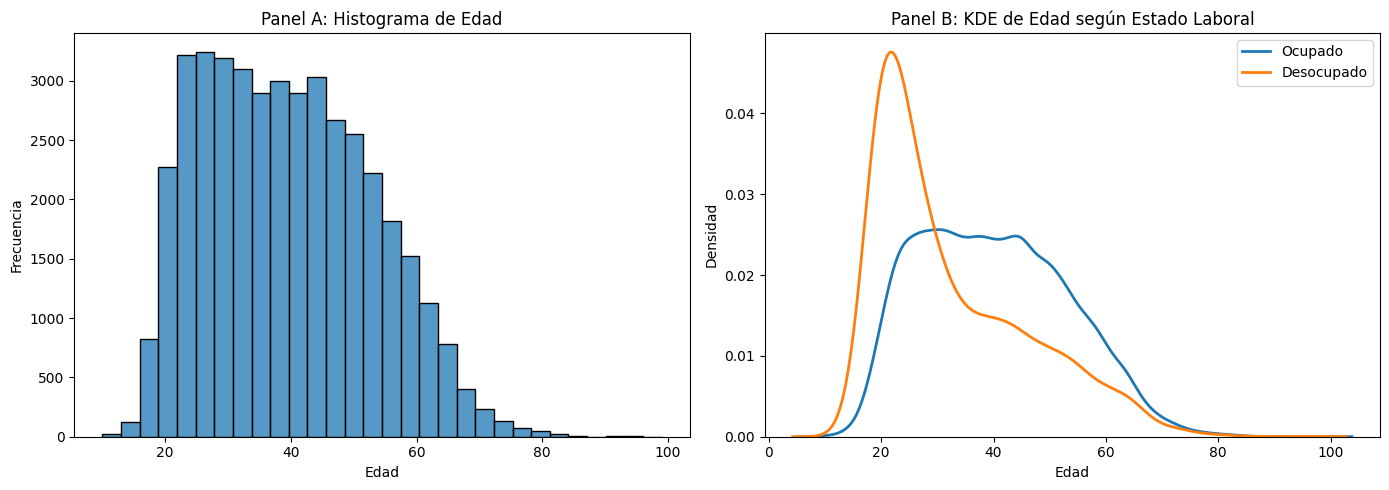

<Figure size 640x480 with 0 Axes>

In [120]:
# PARTE 1-1
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CARGO DE DATOS
df_2004 = pd.read_stata("usu_individual_t104.dta")
df_2024 = pd.read_excel("usu_individual_T124.xlsx", usecols="A:AH")

# NORMALIZO NOMBRES
df_2004.columns = df_2004.columns.str.lower()
df_2024.columns = df_2024.columns.str.lower()

df_2004["año"] = 2004
df_2024["año"] = 2024

# UNIFICO VARIABLES
df = pd.concat([
    df_2004[["ch04", "ch06", "estado", "año"]],
    df_2024[["ch04", "ch06", "estado", "año"]]
], ignore_index=True)

# Sexo: 1 = Hombre, 2 = Mujer
def map_sexo(ch04):
    if isinstance(ch04, str):
        return 1 if ch04.lower().strip() in ["hombre", "varón"] else 2
    return ch04

df["sexo"] = df["ch04"].apply(map_sexo)

# Edad: convierto y limpio
df["edad"] = pd.to_numeric(df["ch06"], errors="coerce")

# Estado laboral
df["estado"] = df["estado"].replace({1: "Ocupado", 2: "Desocupado"})

# Elimino nulos
df = df[df["estado"].isin(["Ocupado", "Desocupado"]) & df["edad"].notna()]

# Creo edad2
df["edad2"] = df["edad"] ** 2

# GRÁFICOS
plt.figure(figsize=(14, 5))

# Panel A: Histograma
plt.subplot(1, 2, 1)
sns.histplot(df["edad"], bins=30, kde=False)
plt.title("Panel A: Histograma de Edad")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")

# Panel B: KDE por estado
plt.subplot(1, 2, 2)
sns.kdeplot(data=df[df["estado"] == "Ocupado"], x="edad", label="Ocupado", linewidth=2)
sns.kdeplot(data=df[df["estado"] == "Desocupado"], x="edad", label="Desocupado", linewidth=2)
plt.title("Panel B: KDE de Edad según Estado Laboral")
plt.xlabel("Edad")
plt.ylabel("Densidad")
plt.legend()

plt.tight_layout()
plt.show()

# Guardamos el gráfico
plt.savefig("histograma_y_kde.png")


In [121]:
# PARTE 1-2
import pandas as pd

# Cargo base combinada con columnas necesarias
df_2004 = pd.read_stata("usu_individual_t104.dta")
df_2024 = pd.read_excel("usu_individual_T124.xlsx", usecols="A:AH", nrows=1000)

# Estandarizo columnas
df_2004.columns = df_2004.columns.str.lower()
df_2024.columns = df_2024.columns.str.lower()
df_2004["año"] = 2004
df_2024["año"] = 2024

# Concateno
df = pd.concat([
    df_2004[["ch12", "ch13", "ch14", "año"]],
    df_2024[["ch12", "ch13", "ch14", "año"]]
], ignore_index=True)

# Función para calcular años de educación
def calcular_educacion(row):
    nivel = row["ch12"]
    finalizado = row["ch13"]
    ultimo_anio = row["ch14"]

    if pd.isnull(nivel):
        return None
    if nivel == 1:  # Sin instrucción
        return 0
    if nivel in [2, 3] and finalizado == 2:
        return min(ultimo_anio, 6) if pd.notnull(ultimo_anio) else 0
    if nivel in [2, 3] and finalizado == 1:
        return 7
    if nivel in [4, 5] and finalizado == 2:
        return 7 + (ultimo_anio if pd.notnull(ultimo_anio) else 0)
    if nivel in [4, 5] and finalizado == 1:
        return 12
    if nivel == 6:
        return 12 + (3 if finalizado == 1 else (ultimo_anio if pd.notnull(ultimo_anio) else 0))
    if nivel == 7:
        return 12 + (5 if finalizado == 1 else (ultimo_anio if pd.notnull(ultimo_anio) else 0))
    if nivel == 8:
        return 18
    return None

# Aplico cálculo
df["educ"] = df.apply(calcular_educacion, axis=1)

# Estadísticas descriptivas
print("Estadísticas descriptivas de la variable 'educ':")
print(df["educ"].describe(percentiles=[0.5]))


Estadísticas descriptivas de la variable 'educ':
count    961.000000
mean      10.141519
std        7.158820
min        0.000000
50%       11.000000
max      111.000000
Name: educ, dtype: float64


In [122]:
# Filtro valores posibles: entre 0 y 23 años de educación
df_limpio = df[(df["educ"] >= 0) & (df["educ"] <= 23)]

# Recalculo estadísticas descriptivas
print("Estadísticas descriptivas de 'educ' (limpia):")
print(df_limpio["educ"].describe(percentiles=[0.5]))


Estadísticas descriptivas de 'educ' (limpia):
count    958.000000
mean       9.830898
std        4.522394
min        0.000000
50%       11.000000
max       18.000000
Name: educ, dtype: float64


<ipython-input-125-dde0bab16b7d>:51: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df[df["estado"] == "Desocupado"], x="salario_semanal", label="Desocupado", linewidth=2)


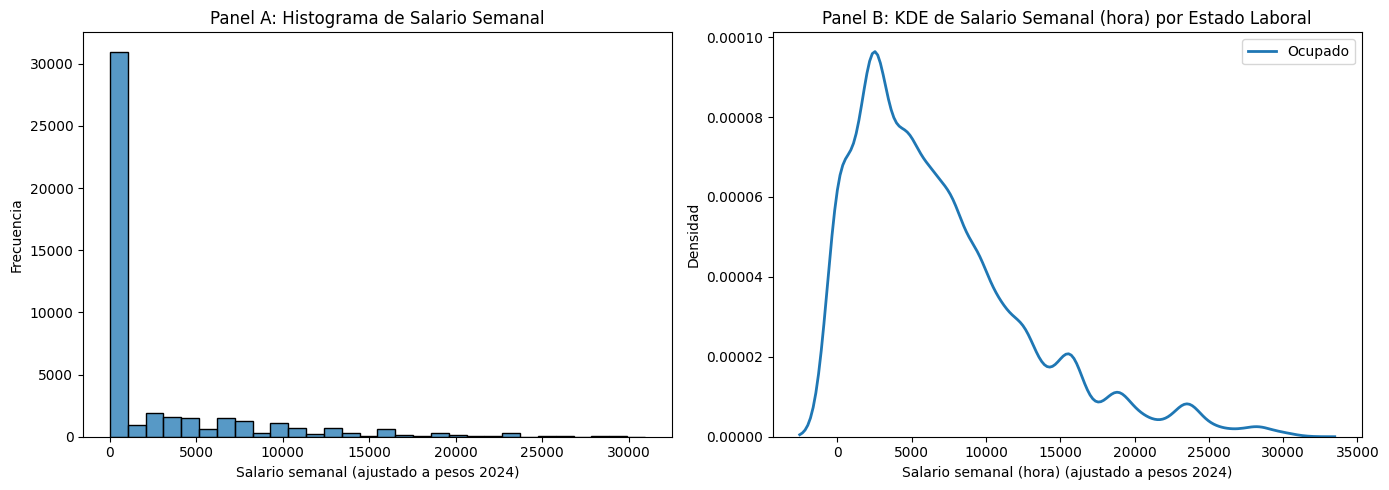

In [125]:
# @title Default title text
#PARTE 1-3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_2004 = pd.read_stata("usu_individual_t104.dta")
df_2024 = pd.read_excel("usu_individual_T124.xlsx", nrows=1000)  # incluir p21

# Normalizo columnas
df_2004.columns = df_2004.columns.str.lower()
df_2024.columns = df_2024.columns.str.lower()
df_2004["año"] = 2004
df_2024["año"] = 2024

# Unifico variables
df = pd.concat([
    df_2004[["p21", "estado", "año"]],
    df_2024[["p21", "estado", "año"]]
], ignore_index=True)

# Ajusto a pesos constantes
factor_ajuste = 628.26
df["p21_ajustada"] = df.apply(
    lambda row: row["p21"] * factor_ajuste if row["año"] == 2004 else row["p21"],
    axis=1
)

# Calculo salario semanal
df["salario_semanal"] = df["p21_ajustada"] / 40

#PARTE 1-3a
# Limpieza para graficar
df = df[df["salario_semanal"].notna()]
df = df[df["salario_semanal"] < df["salario_semanal"].quantile(0.99)]
df["estado"] = df["estado"].replace({1: "Ocupado", 2: "Desocupado"})

# Grafico
plt.figure(figsize=(14, 5))

# Panel A: Histograma
plt.subplot(1, 2, 1)
sns.histplot(df["salario_semanal"], bins=30)
plt.title("Panel A: Histograma de Salario Semanal")
plt.xlabel("Salario semanal (ajustado a pesos 2024)")
plt.ylabel("Frecuencia")

# Panel B: KDE por estado laboral
plt.subplot(1, 2, 2)
sns.kdeplot(data=df[df["estado"] == "Ocupado"], x="salario_semanal", label="Ocupado", linewidth=2)
sns.kdeplot(data=df[df["estado"] == "Desocupado"], x="salario_semanal", label="Desocupado", linewidth=2)
plt.title("Panel B: KDE de Salario Semanal (hora) por Estado Laboral")
plt.xlabel("Salario semanal (hora) (ajustado a pesos 2024)")
plt.ylabel("Densidad")
plt.legend()

plt.tight_layout()
plt.show()

In [126]:
#PARTE 1-4
import pandas as pd

df_2004 = pd.read_stata("usu_individual_t104.dta")
df_2024 = pd.read_excel("usu_individual_T124.xlsx", usecols=None, nrows=1000)

#Estandarizo columnas y agregar año
df_2004.columns = df_2004.columns.str.lower()
df_2024.columns = df_2024.columns.str.lower()
df_2004["año"] = 2004
df_2024["año"] = 2024

#Concateno variables necesarias
df = pd.concat([
    df_2004[["pp3e_tot", "pp3f_tot", "estado"]],
    df_2024[["pp3e_tot", "pp3f_tot", "estado"]]
], ignore_index=True)

#Creo horas trabajadas totales semanales
df["horastrab"] = df["pp3e_tot"].fillna(0) + df["pp3f_tot"].fillna(0)

#Filtro: ocupados, horas > 0 y <= 84
df_filtrado = df[
    (df["estado"] == 1) &
    (df["horastrab"] > 0) &
    (df["horastrab"] <= 84)
]

#Estadísticas descriptivas
print("Estadísticas descriptivas de 'horastrab' (ocupados con horas > 0 y <= 84):")
print(df_filtrado["horastrab"].describe(percentiles=[0.5]))



Estadísticas descriptivas de 'horastrab' (ocupados con horas > 0 y <= 84):
count    404.000000
mean      38.542079
std       16.147912
min        1.000000
50%       40.000000
max       84.000000
Name: horastrab, dtype: float64


In [127]:
import pandas as pd

# --- Cargar base 2004 ---
df_2004 = pd.read_stata("usu_individual_t104.dta", columns=["estado", "aglomerado"])
df_2004["año"] = 2004
df_2004["estado"] = df_2004["estado"].astype("object").replace({"Ocupado": 1, "Desocupado": 2})

# Filtro CABA por nombre (base 2004 usa nombres)
df_2004_caba = df_2004[df_2004["aglomerado"] == "Ciudad de Buenos Aires"]

# --- Cargar base 2024 ---
df_2024 = pd.read_excel("usu_individual_T124.xlsx", usecols=["ESTADO", "AGLOMERADO"])
df_2024.columns = df_2024.columns.str.lower()  # estandarizar
df_2024["año"] = 2024

# Filtro CABA por código (base 2024 usa código)
df_2024_caba = df_2024[df_2024["aglomerado"] == 32]

# --- Función resumen ---
def resumen_estado(df):
    obs = len(df)
    nas = df["estado"].isna().sum()
    ocup = (df["estado"] == 1).sum()
    desocup = (df["estado"] == 2).sum()
    columnas = df.shape[1]
    return [obs, nas, ocup, desocup, columnas]

val_2004 = resumen_estado(df_2004_caba)
val_2024 = resumen_estado(df_2024_caba)
val_total = [val_2004[i] + val_2024[i] for i in range(4)] + [val_2024[-1]]

# Creo tabla final
tabla = pd.DataFrame({
    "2004": val_2004,
    "2024": val_2024,
    "Total": val_total
}, index=[
    "Cantidad de observaciones",
    "Cantidad de NaNs en 'estado'",
    "Cantidad de ocupados",
    "Cantidad de desocupados",
    "Variables limpias y homogeneizadas"
])

print(tabla)




                                    2004  2024  Total
Cantidad de observaciones           1836  1422   3258
Cantidad de NaNs en 'estado'           0     0      0
Cantidad de ocupados                 838   757   1595
Cantidad de desocupados              119    51    170
Variables limpias y homogeneizadas     3     3      3


In [129]:
#PARTE 2-1
df_caba = df_caba.copy()

# Creo edad y edad2
df_caba["edad"] = df_caba["ch06"]
df_caba["edad2"] = df_caba["edad"] ** 2

def calcular_educ(row):
    if row["ch12"] == 1:  # sin instrucción
        return 0
    if row["ch12"] == 2:  # inicial
        return 1 if row["ch13"] == 1 else 0
    if row["ch12"] == 3:  # primario
        return row["ch14"] if row["ch13"] == 1 else row["ch14"] - 1
    if row["ch12"] == 4:  # secundario
        return 7 + row["ch14"] if row["ch13"] == 1 else 7 + row["ch14"] - 1
    if row["ch12"] == 5:  # terciario / universitario
        return 13 + row["ch14"] if row["ch13"] == 1 else 13 + row["ch14"] - 1
    if row["ch12"] == 6:  # posgrado
        return 18
    return None

df_caba["educ"] = df_caba.apply(calcular_educ, axis=1)

# Ajusto pesos de 2004 si aún no están
df_caba["salario_semanal"] = df_caba.apply(
    lambda x: (x["p21"] * 628.26 / 40) if x["año"] == 2004 else x["p21"] / 40,
    axis=1)
df_caba["horastrab"] = df_caba["pp3e_tot"] + df_caba["pp3f_tot"]

# Elimino outliers absurdos
df_caba = df_caba[df_caba["horastrab"] <= 84]
vars_corr = ["edad", "edad2", "educ", "salario_semanal", "horastrab"]
df_corr = df_caba[vars_corr].dropna()

import seaborn as sns
import matplotlib.pyplot as plt

# Creo diccionario de nombres más claros para el gráfico
nombres = {
    "edad": "Edad",
    "edad2": "Edad²",
    "educ": "Años de educación",
    "salario_semanal": "Salario semanal (ajustado)",
    "horastrab": "Horas trabajadas"
}

# Subset de datos y renombrado de columnas
vars_corr = list(nombres.keys())
df_corr = df_caba[vars_corr].dropna().rename(columns=nombres)

# Grafico matriz de correlación
plt.figure(figsize=(9, 7))
sns.heatmap(df_corr.corr(), annot=True, cmap="YlGnBu", fmt=".2f",
            linewidths=0.5, square=True, cbar_kws={"shrink": 0.8})
plt.title("Matriz de correlación - Región CABA", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

plt.savefig('matrizcorrelación.png', bbox_inches='tight', dpi=300)







KeyError: 'ch06'

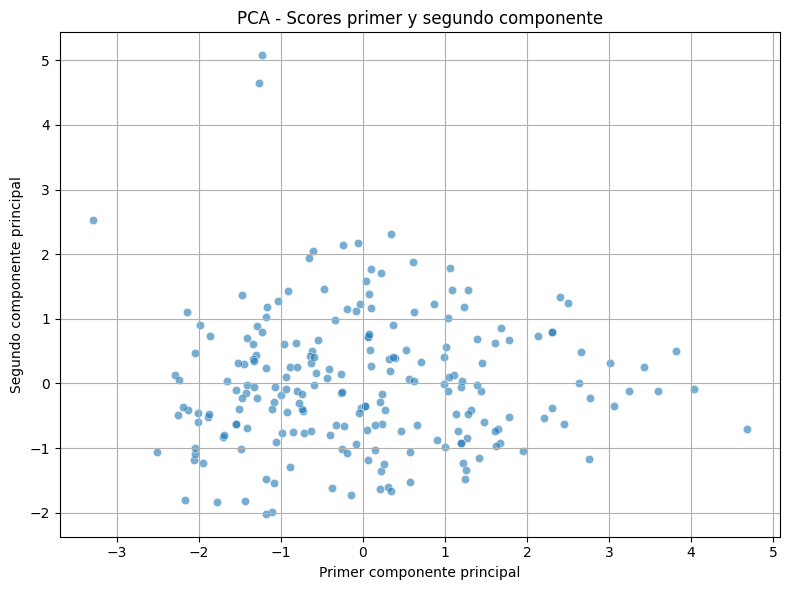

Varianza explicada por cada componente:
PC1: 41.78%
PC2: 21.68%


In [71]:
#PARTE 2-2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Filtro sólo ocupados y desocupados
df_pca = df_caba[df_caba["estado"].isin([1, 2])].copy()

# 2. Selecciono variables
vars_pca = ["edad", "edad2", "educ", "salario_semanal", "horastrab"]
df_pca_clean = df_pca[vars_pca].dropna()

# 3. Estandarizo
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pca_clean)

# 4. Aplico PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 5. Creo DataFrame con scores
df_scores = pd.DataFrame(X_pca, columns=["PC1", "PC2"])

# 6. Gráfico de dispersión
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_scores, x="PC1", y="PC2", alpha=0.6)
plt.title("PCA - Scores primer y segundo componente")
plt.xlabel("Primer componente principal")
plt.ylabel("Segundo componente principal")
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Muestro varianza explicada
print("Varianza explicada por cada componente:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {var:.2%}")


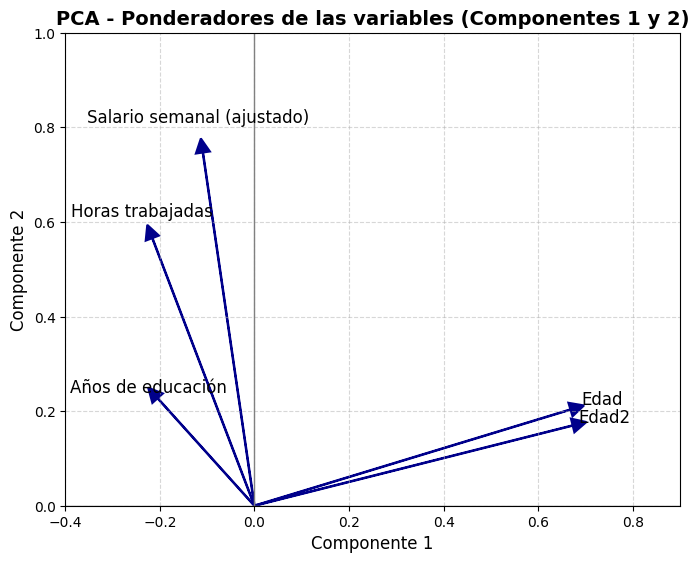

In [75]:
#PARTE 2-3
import matplotlib.pyplot as plt

# Nombres descriptivos de las variables
features = [
    "Edad",
    "Edad2",
    "Años de educación",
    "Salario semanal (ajustado)",
    "Horas trabajadas"
]

# Usamos los loadings reales del PCA
loadings = pca.components_.T

# Crear gráfico decorado
plt.figure(figsize=(7, 6))
for i, var in enumerate(features):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1],
              head_width=0.03, head_length=0.03, color='darkblue', linewidth=1.5)
    plt.text(loadings[i, 0]*1.1, loadings[i, 1]*1.1, var, fontsize=12, ha='center', va='center')

# Decoración
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.xlim(-0.4, 0.9)
plt.ylim(0, 1.0)
plt.xlabel("Componente 1", fontsize=12)
plt.ylabel("Componente 2", fontsize=12)
plt.title("PCA - Ponderadores de las variables (Componentes 1 y 2)", fontsize=14, fontweight='bold')
plt.grid(True, linestyle="--", alpha=0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()



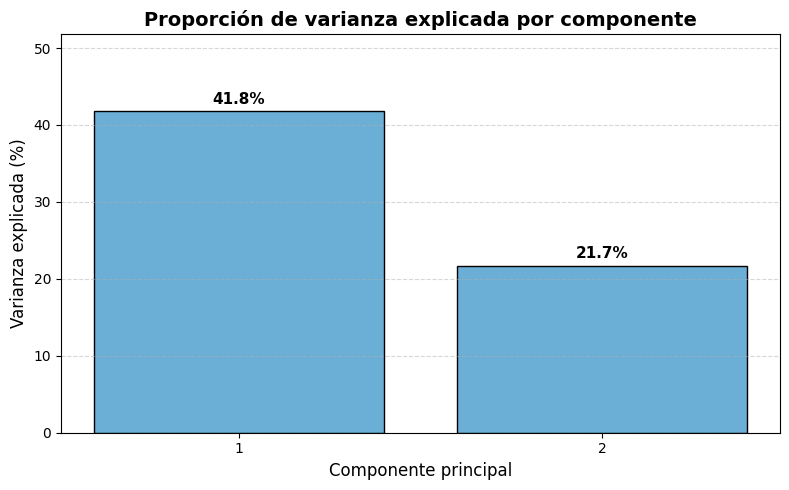

In [77]:
#PARTE 2-4
import matplotlib.pyplot as plt
import numpy as np

components = np.arange(1, len(explained_var) + 1)

# Creo gráfico
plt.figure(figsize=(8, 5))
bars = plt.bar(components, explained_var * 100, color="#6baed6", edgecolor="black")

# Etiquetas de porcentaje encima de cada barra
for bar, val in zip(bars, explained_var * 100):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f"{val:.1f}%", ha='center', fontsize=11, fontweight='bold')

# Decoración
plt.xlabel("Componente principal", fontsize=12)
plt.ylabel("Varianza explicada (%)", fontsize=12)
plt.title("Proporción de varianza explicada por componente", fontsize=14, fontweight='bold')
plt.xticks(components)
plt.ylim(0, max(explained_var) * 100 + 10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


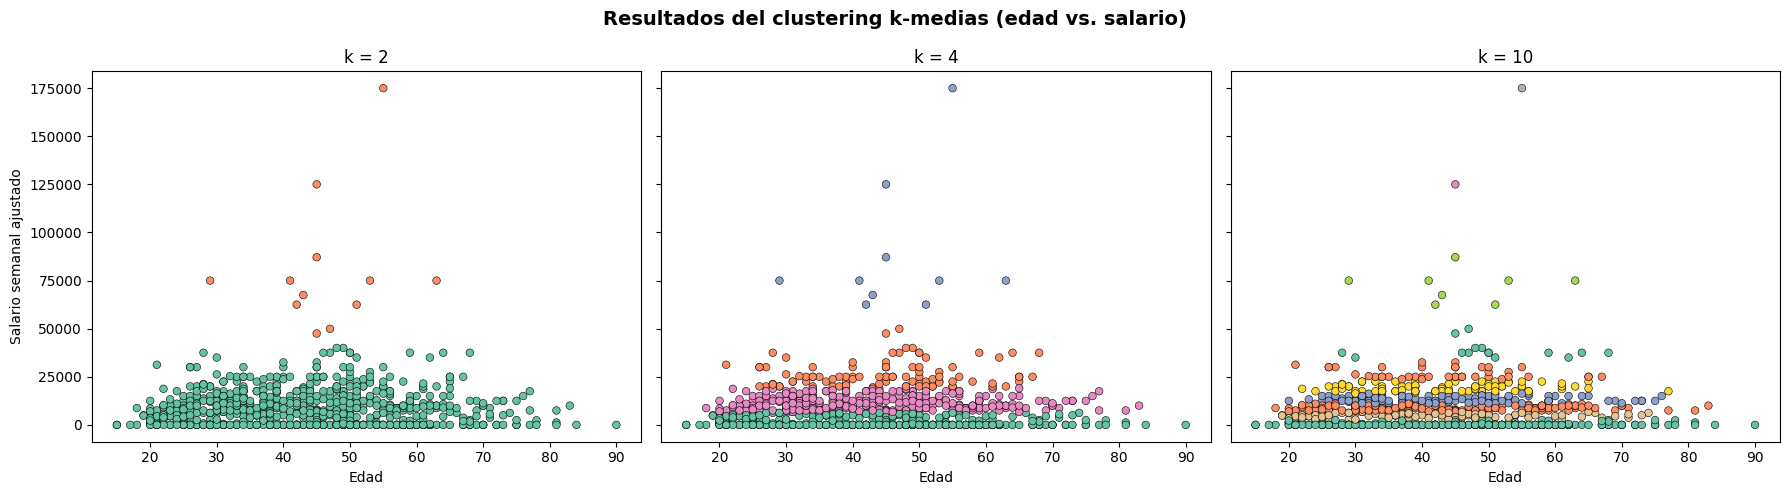

In [78]:
#PARTE 2-5a
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Filtro datos válidos
X_cluster = df_caba[["edad", "salario_semanal"]].dropna()

# Valores de k a usar
ks = [2, 4, 10]

# Creo subplots
fig, axes = plt.subplots(1, len(ks), figsize=(18, 5), sharey=True)

for i, k in enumerate(ks):
    # Ejecuto k-means
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
    clusters = kmeans.fit_predict(X_cluster)

    # Gráfico
    ax = axes[i]
    sns.scatterplot(
        x=X_cluster["edad"],
        y=X_cluster["salario_semanal"],
        hue=clusters,
        palette="Set2",
        s=30,
        edgecolor="black",
        linewidth=0.4,
        ax=ax,
        legend=False
    )
    ax.set_title(f"k = {k}", fontsize=12)
    ax.set_xlabel("Edad")
    if i == 0:
        ax.set_ylabel("Salario semanal ajustado")
    else:
        ax.set_ylabel("")

plt.suptitle("Resultados del clustering k-medias (edad vs. salario)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


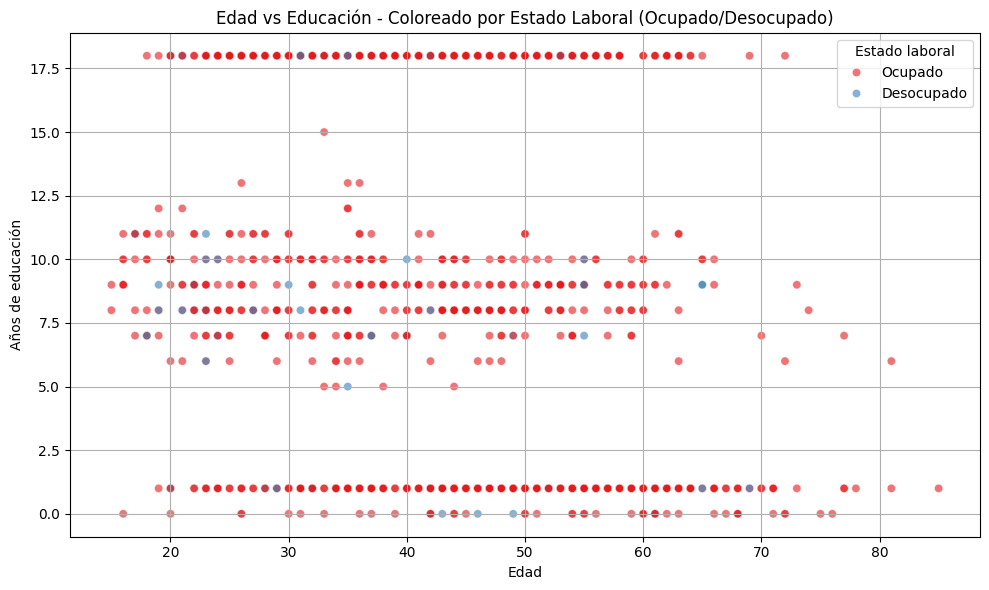

In [135]:
#PARTE 5b
import pandas as pd

# Volví a hacerlo de nuevo porque no encontraba mi error
# Cargo datos
df_2004 = pd.read_stata("usu_individual_t104.dta")
columnas = ["CH06", "CH12", "CH13", "CH14", "P21", "PP3E_TOT", "PP3F_TOT", "ESTADO"]
df_2024 = pd.read_excel("usu_individual_T124.xlsx", usecols=columnas, nrows=5000)

# Estandarizo nombres de columnas
df_2004.columns = df_2004.columns.str.upper()
df_2024.columns = df_2024.columns.str.upper()
df_2004["AÑO"] = 2004
df_2024["AÑO"] = 2024

# Uno ambos datasets
df_caba = pd.concat([df_2004[columnas + ["AÑO"]], df_2024[columnas + ["AÑO"]]], ignore_index=True)

# Renombro columnas
df_caba = df_caba.rename(columns={
    "CH06": "edad",
    "CH12": "nivel",
    "CH13": "finalizado",
    "CH14": "ultimo_año",
    "P21": "ingreso",
    "PP3E_TOT": "horas_principal",
    "PP3F_TOT": "horas_secundaria",
    "ESTADO": "estado"
})

# Convierto a numérico
cols_numericas = ["edad", "nivel", "finalizado", "ultimo_año", "ingreso", "horas_principal", "horas_secundaria", "estado"]
for col in cols_numericas:
    df_caba[col] = pd.to_numeric(df_caba[col], errors="coerce")

# Edad al cuadrado
df_caba["edad2"] = df_caba["edad"] ** 2

# Calculo educación
def calcular_educ(row):
    if row["nivel"] == 1: return 0
    if row["nivel"] == 2: return 1 if row["finalizado"] == 1 else 0
    if row["nivel"] == 3: return row["ultimo_año"] if row["finalizado"] == 1 else row["ultimo_año"] - 1
    if row["nivel"] == 4: return 7 + row["ultimo_año"] if row["finalizado"] == 1 else 7 + row["ultimo_año"] - 1
    if row["nivel"] == 5: return 13 + row["ultimo_año"] if row["finalizado"] == 1 else 13 + row["ultimo_año"] - 1
    if row["nivel"] == 6: return 18
    return None

df_caba["educ"] = df_caba.apply(calcular_educ, axis=1)

# Calculo salario semanal (ajustado 2004 con 628.26)
df_caba["salario_semanal"] = df_caba.apply(
    lambda x: (x["ingreso"] * 628.26 / 40) if x["AÑO"] == 2004 else x["ingreso"] / 40,
    axis=1
)

# Total de horas trabajadas
df_caba["horastrab"] = df_caba[["horas_principal", "horas_secundaria"]].sum(axis=1)

# Estado laboral en texto
df_caba["estado_ocupacional"] = df_caba["estado"].map({1: "Ocupado", 2: "Desocupado"})

import matplotlib.pyplot as plt
import seaborn as sns

# Filtro datos válidos
df_filtrado = df_caba[
    df_caba["educ"].notna() &
    df_caba["edad"].notna() &
    df_caba["estado_ocupacional"].notna() &
    (df_caba["educ"] <= 25)
]


# Creo gráfico
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_filtrado,
    x="edad",
    y="educ",
    hue="estado_ocupacional",
    palette="Set1",
    alpha=0.6
)

# Personalización del gráfico
plt.title("Edad vs Educación - Coloreado por Estado Laboral (Ocupado/Desocupado)")
plt.xlabel("Edad")
plt.ylabel("Años de educación")
plt.grid(True)
plt.legend(title="Estado laboral")
plt.tight_layout()
plt.show()




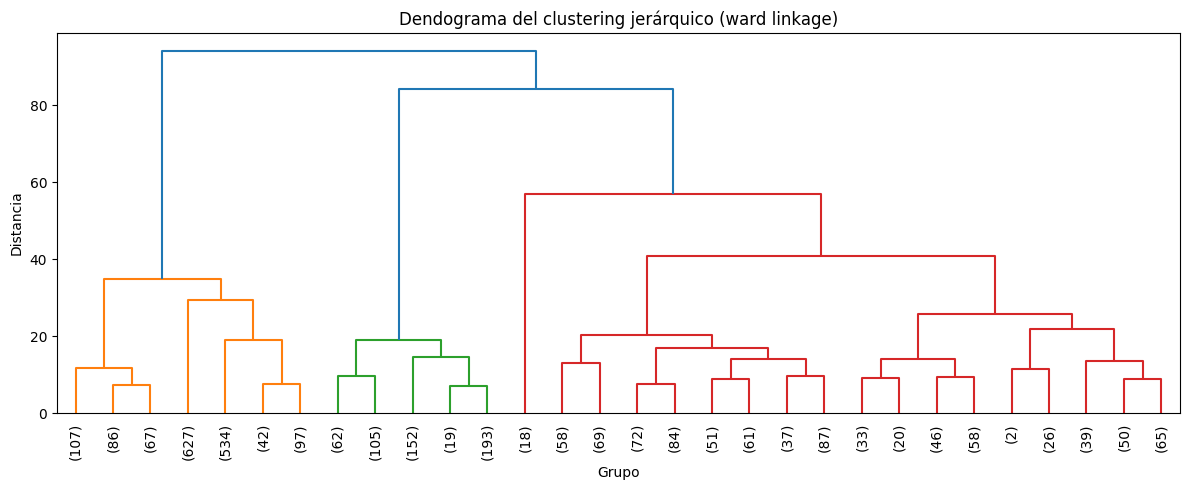

In [136]:
#PARTE 6
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Variables seleccionadas
variables_cluster = ["edad", "edad2", "educ", "salario_semanal", "horastrab"]

# Filtro y escalo datos válidos
df_cluster = df_caba.dropna(subset=variables_cluster).copy()
X = df_cluster[variables_cluster]

# Escalo (normalizar)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calculo clustering jerárquico
linked = linkage(X_scaled, method='ward')

# Dendograma
plt.figure(figsize=(12, 5))
dendrogram(linked, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendograma del clustering jerárquico (ward linkage)")
plt.xlabel("Grupo")
plt.ylabel("Distancia")
plt.tight_layout()
plt.show()


